In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Load dataset
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train1.csv',header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv',header=None)

In [ ]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 1001
Number of samples in test data: 596


In [ ]:
# Explore the dataset
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.424,0.792,1.000,0.2570,0.0000,0.2780,0.4650,0.5210,0.4720,0.5560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [ ]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 6


In [ ]:
print(train_data.iloc[:, -1].value_counts())  #Change the datatype to float and get the unique values in the last column to see how many rows in every class and store them in equilibre variable and print them# Check class distribution in train data

187
3.0    208
2.0    202
0.0    200
1.0    200
4.0    191
Name: count, dtype: int64


In [ ]:
print(test_data.iloc[:, -1].value_counts())  # Check class distribution in test data

187
4.0    196
0.0    101
2.0    100
3.0    100
1.0     99
Name: count, dtype: int64


In [ ]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.00000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.837096,0.736592,0.484529,0.319235,0.275040,0.263708,0.248373,0.236242,0.226279,0.209086,...,0.01265,0.012527,0.011540,0.011562,0.012014,0.012500,0.012403,0.011410,0.011563,1.990010
std,0.283989,0.268824,0.254477,0.246555,0.220343,0.207018,0.204322,0.195540,0.182487,0.173932,...,0.06800,0.068515,0.062093,0.062480,0.065566,0.069336,0.070062,0.063842,0.064116,1.404244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.812000,0.616000,0.291000,0.123000,0.114000,0.120000,0.102000,0.087100,0.086400,0.082500,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.973000,0.836000,0.492000,0.283000,0.197000,0.180000,0.161000,0.170000,0.171000,0.158000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,0.928000,0.664000,0.463000,0.393000,0.379000,0.372000,0.352000,0.313000,0.283000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988000,0.992000,0.965000,0.969000,...,0.90900,0.927000,0.645000,0.657000,0.751000,0.921000,1.000000,0.672000,0.742000,4.000000


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 875.5 KB


In [ ]:
# Assuming the target column is the last column
#Get the unique values in the target column
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [ ]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
for label in labels:
    print(f"Class label {label}: {labels[label]}")

Class label 0: Normal
Class label 1: Artial Premature
Class label 2: Premature ventricular contraction
Class label 3: Fusion of ventricular and normal
Class label 4: Fusion of paced and normal


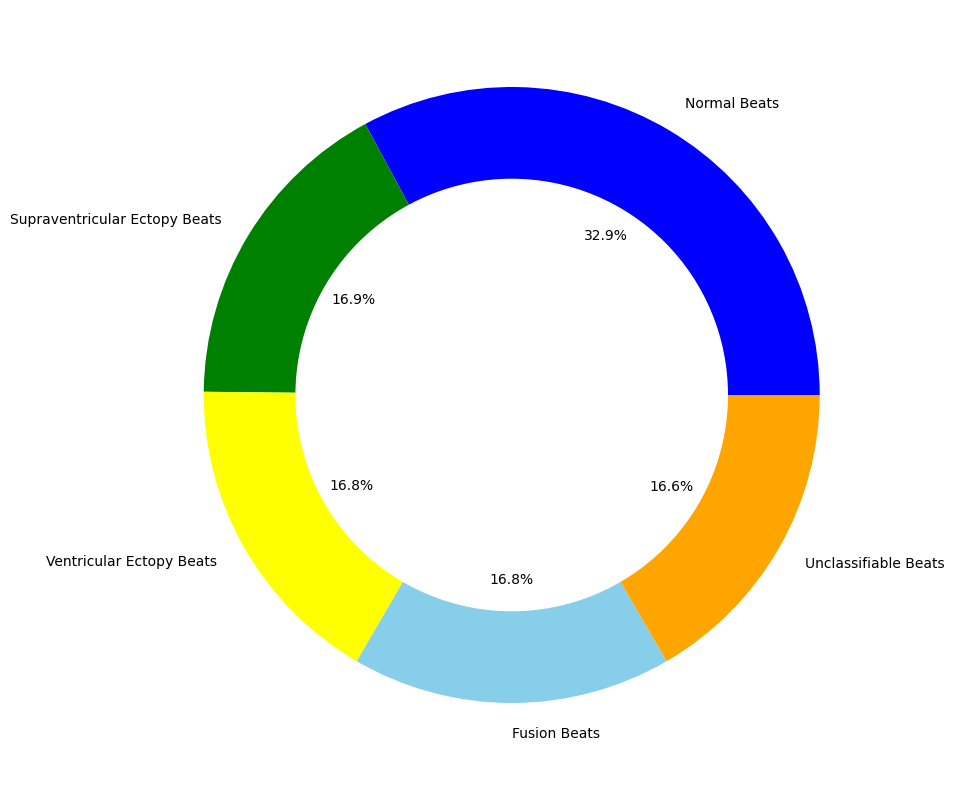

In [ ]:
equilibre = test_data.iloc[:, -1].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats'], colors=['Blue','Green','Yellow','Skyblue','Orange'],autopct='%1.1f%%', textprops={'color': 'black'})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



# New Section

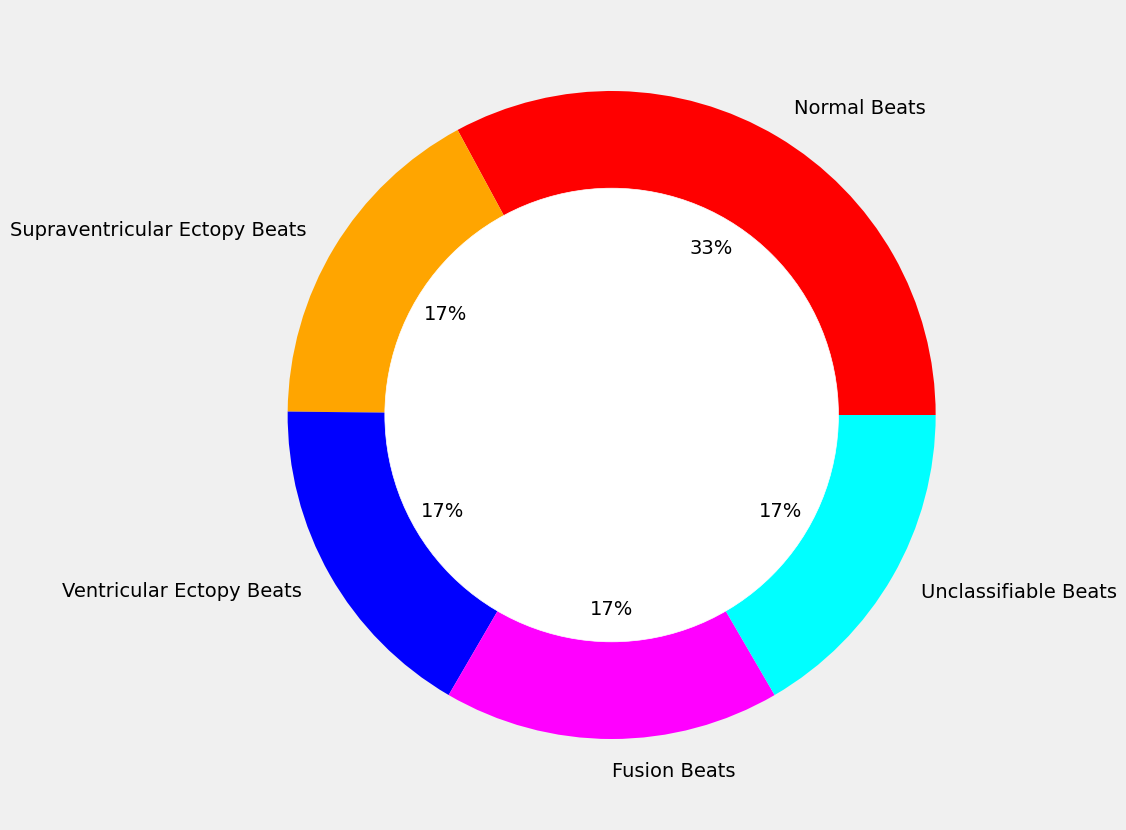

In [ ]:

plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')
plt.pie(test_data[187].value_counts(), labels=['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats'], autopct = '%0.0f%%', colors = ['red','orange','blue','magenta','cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

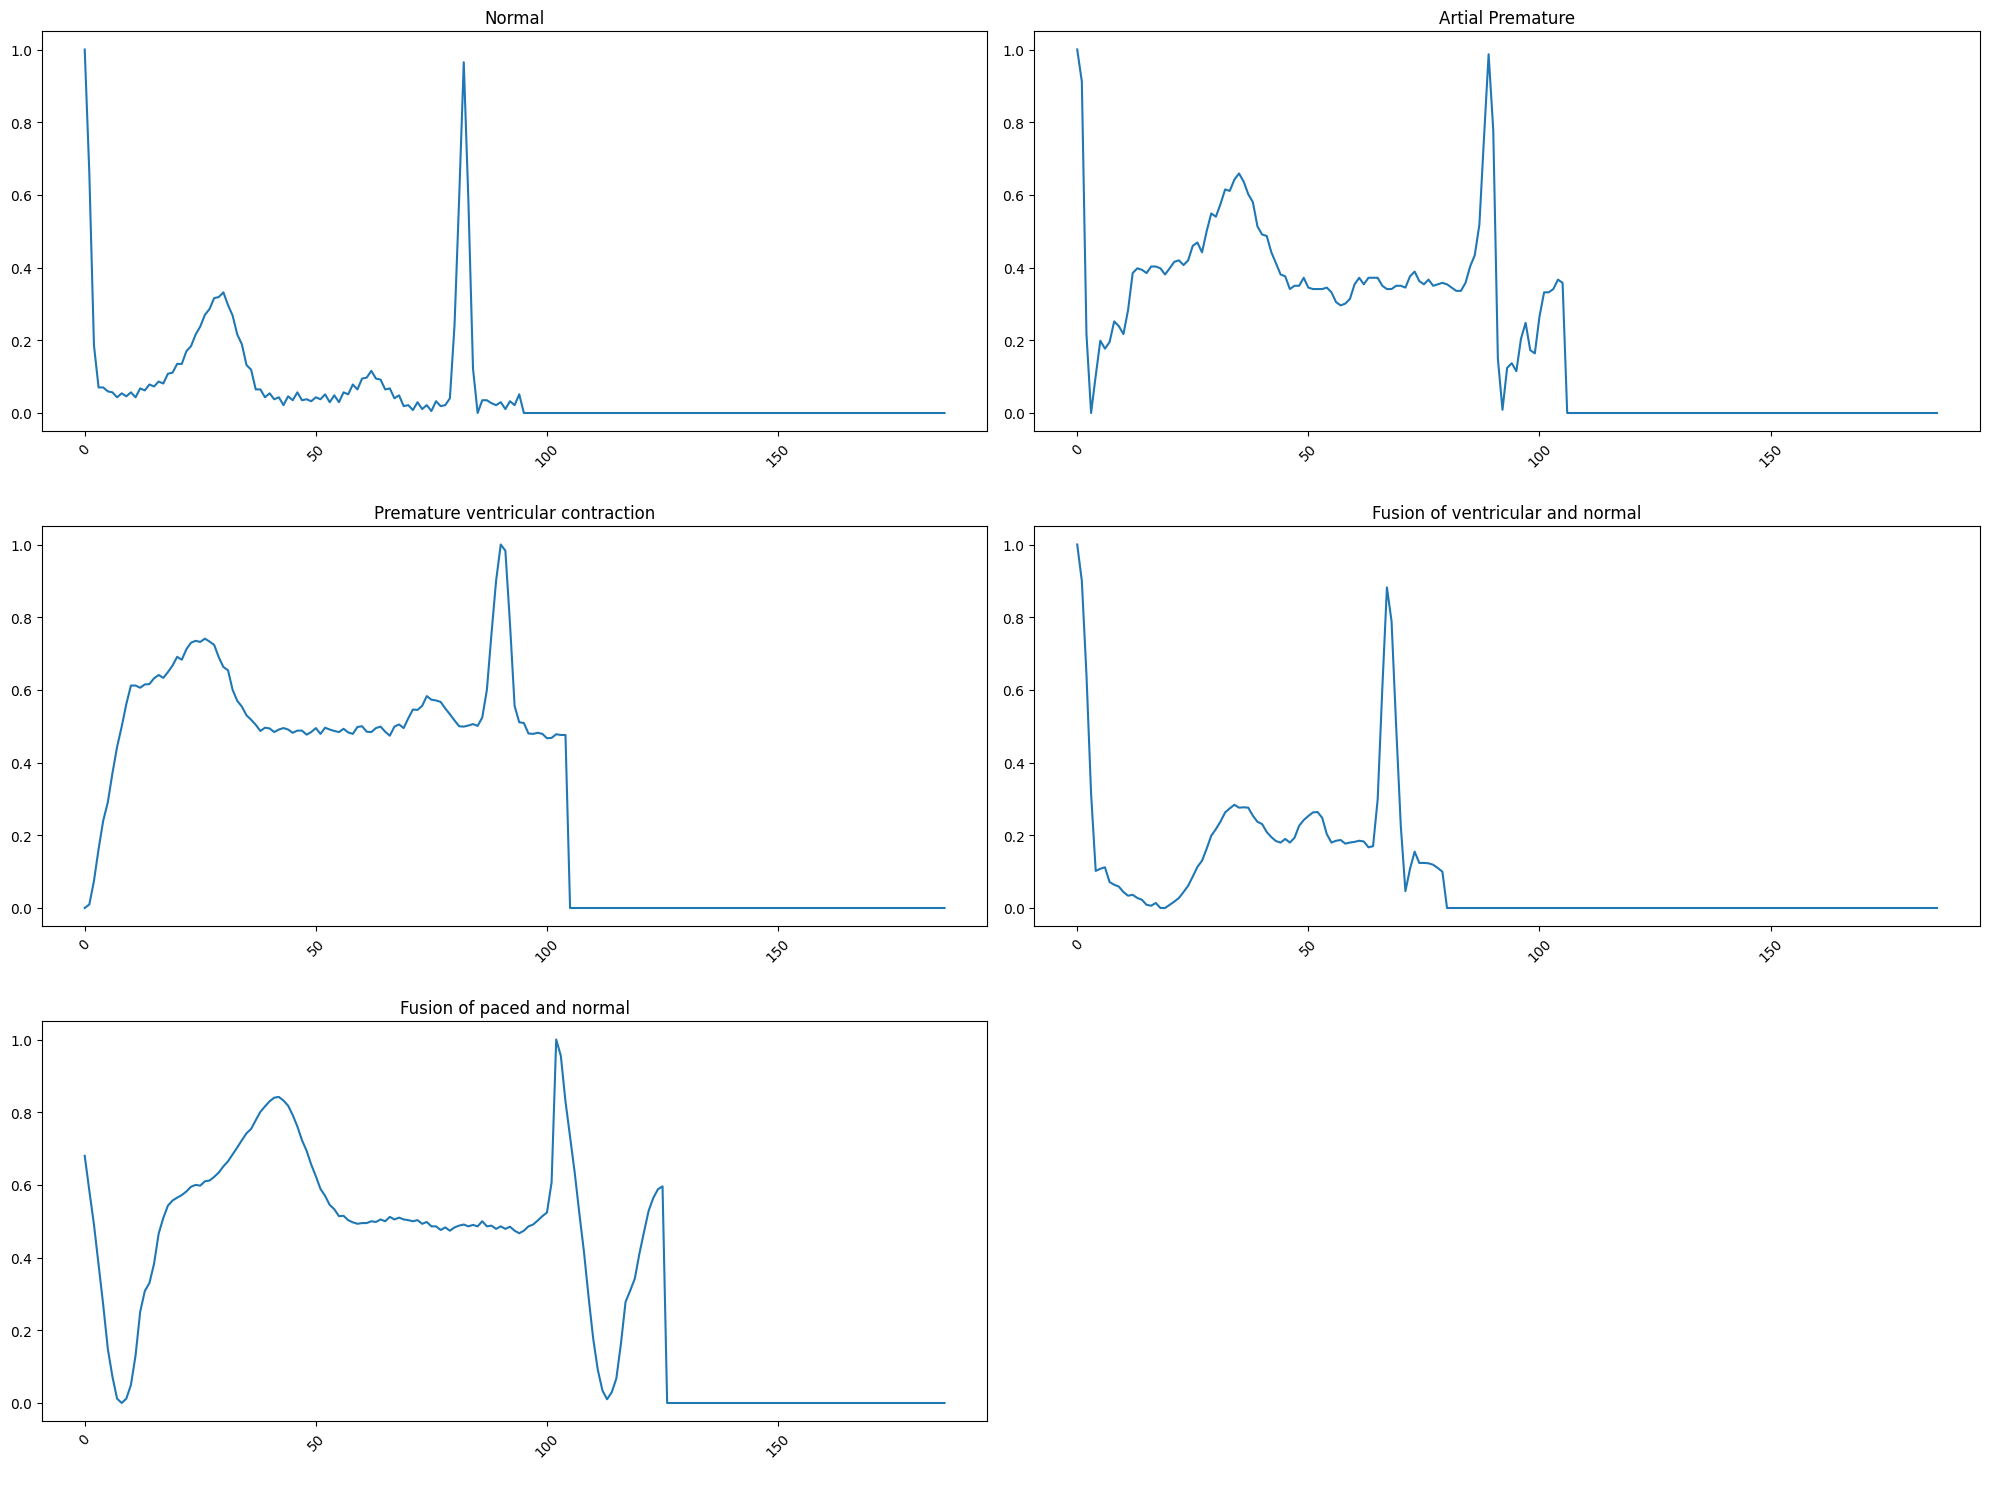

In [ ]:

import matplotlib.pyplot as plt

train_classes = train_data.iloc[:, -1].unique()

plt.figure(figsize=(20, 15))

for i, cls in enumerate(train_classes):
    # Select data for the current class
    class_data = train_data[train_data.iloc[:, -1] == cls]

    # Check if there is data for this class
    if not class_data.empty:
        plt.subplot(3, 2, i + 1)
        plt.plot(class_data.iloc[0, :-1])  # Exclude the label column
        # Accessing list elements directly using index i
        plt.title(f'{labels[i]}')
        plt.xlabel(" ")
        # Remove or replace xticks with valid numeric values
        # plt.xticks(ticks=[0, 50, 100, 150], labels=[0, 50, 100, 150], rotation=45) # Example: Set ticks at specific positions
        # plt.xticks([]) #Example: Remove xticks completely
        plt.xticks(ticks=range(0, len(class_data.iloc[0, :-1]),50) ,labels=range(0, len(class_data.iloc[0, :-1]),50) ,rotation=45)


    else:
        print(f"No data found for class: {cls}")

plt.tight_layout()
plt.show()

In [ ]:

#DATA PREPROCESSING
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))


print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_new.shape[0]}")


New Training set size: 1001
Validation set size: 298
Test set size: 298


In [ ]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
lstm_model = build_lstm_model()

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 187, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,885 (230.02 KB)

 Trainable params: 58,885 (230.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

# ... (Your existing code) ...

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Define the ModelCheckpoint callback (if not already defined)
# Changed 'best_model.h5' to 'best_model.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy',
                                                      save_best_only=True, mode='max', verbose=1)

lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=180,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2046 - loss: 1.6067
Epoch 1: val_accuracy improved from -inf to 0.25503, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.2046 - loss: 1.6065 - val_accuracy: 0.2550 - val_loss: 1.5875 - learning_rate: 0.0010
Epoch 2/180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2509 - loss: 1.5789
Epoch 2: val_accuracy improved from 0.25503 to 0.27852, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.2517 - loss: 1.5785 - val_accuracy: 0.2785 - val_loss: 1.5310 - learning_rate: 0.0010
Epoch 3/180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3863 - loss: 1.4072
Epoch 3: val_accuracy improved from 0.27852 to 0.51007, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.3870 - loss: 1.4062 - val_accuracy: 0.5101 - val_loss: 1.2724 - learning_rate: 0.0010
Epoch 4/180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/st

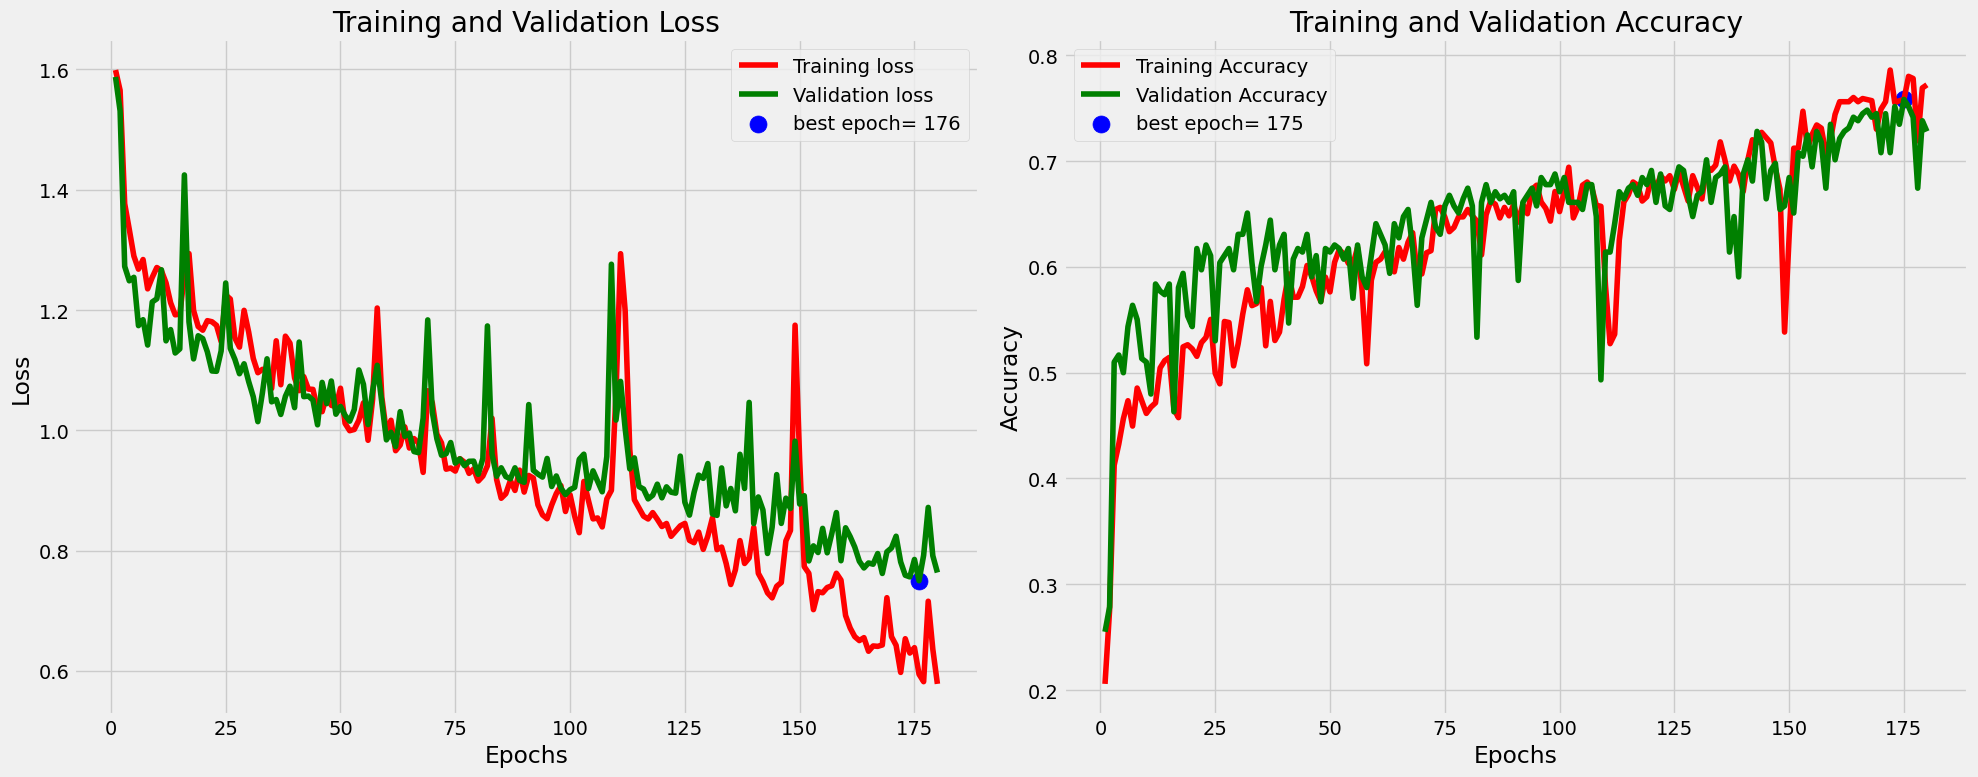

In [ ]:
learning_curves_plot(lstm_history, start_epoch=0)

In [ ]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [ ]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 0.7952
LSTM Test Accuracy: 0.6913


In [ ]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.46      0.47      0.47        51
         1.0       0.63      0.65      0.64        49
         2.0       0.57      0.64      0.60        50
         3.0       0.69      0.80      0.74        50
         4.0       0.96      0.80      0.87        98

    accuracy                           0.69       298
   macro avg       0.66      0.67      0.66       298
weighted avg       0.71      0.69      0.70       298



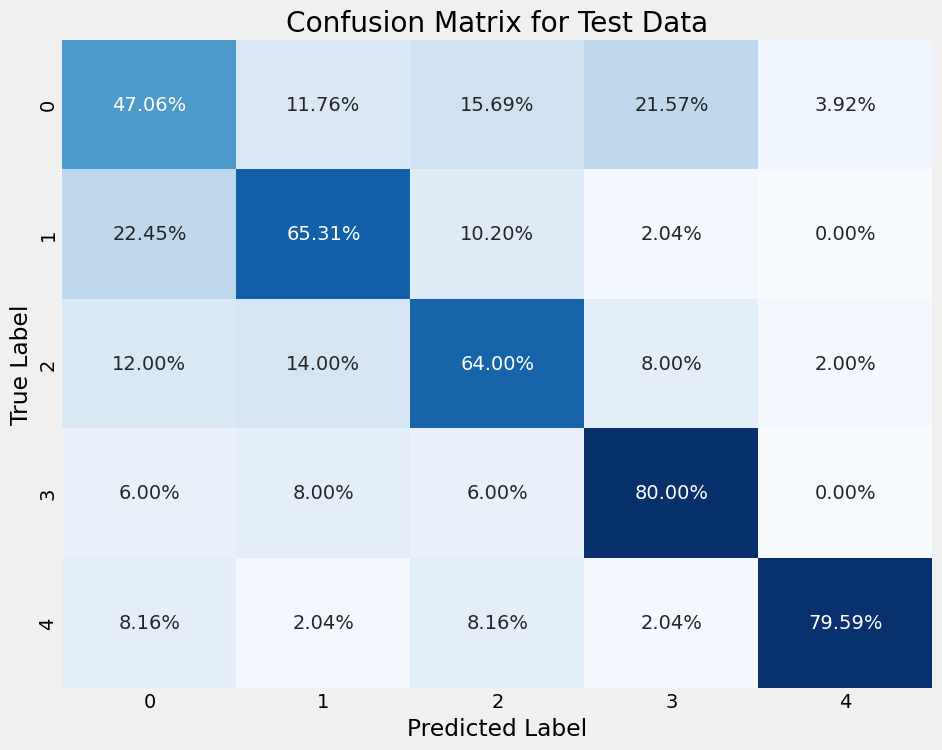

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix as before
conf_matrix = confusion_matrix(y_test_new, y_test_pred_lstm)



# Compute percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
